# Predicting Steam Game Tags from Text Decription
Steps:
- First, load descriptions and tags from the cleaned Steam data. 
- Then, pre-process the text and vectorize it using TF-IDF.
- Then, expand the tags into separate binary features. Only keep the top 30 most frequent tags; The original 424 is too many, since we need to train a separate classifier for each.
- Finally, train a MultiOutputClassifier to predict tags from text features.  
  
Best ROC_AUC score is 0.829.  
Original Dataset: https://www.kaggle.com/datasets/deepann/80000-steam-games-dataset.  
Code written by Ethan Kohrt.



In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ast import literal_eval

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load a sample of the whole dataset (possibly too big)
orig_df = pd.read_csv("/content/drive/MyDrive/CS-396 Data Science Project/datasets/steam_data_json_cleaned.csv", converters={"fixed_tags": literal_eval}) #fixed_tags column contains lists
orig_df = orig_df[['name', 'store_page_url', 'desc', 'fixed_tags']]
# orig_df = orig_df.sample(10000)
orig_df[['name', 'desc', 'fixed_tags']].head(1)

,name,desc,fixed_tags
0,Among Us,About This Game Play with 4-10 player online o...,"[Multiplayer, Online, Space, Social Deduction,..."


# EDA
Look at tag frequency

There are 424 unique tags.
Indie           35585
Action          24100
Adventure       20855
Casual          19687
Singleplayer    16765
Strategy        10960
Simulation      10184
Puzzle           8257
2D               7682
Early Access     6768
dtype: int64
      ...
-.               4
F                3
Photo Editing    3
Jet              2
+                1
-op              1
Crawler          1
Outbreak Sim     1
Medical Sim      1
G                1
dtype: int64


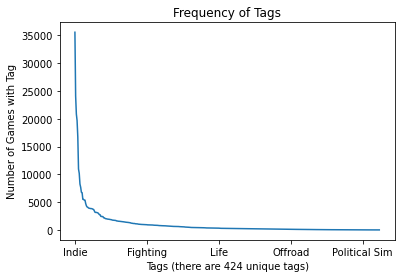

In [ ]:
# first, let's explore: how many of each tag are there?
just_tags = pd.Series([item for sublist in orig_df.fixed_tags for item in sublist])
counts = just_tags.value_counts()

print(f"There are {just_tags.nunique()} unique tags.")
print( counts.head(10) )
print("      ...")
print( counts.tail(10) )
counts.plot(title= 'Frequency of Tags', xlabel = 'Tags (there are 424 unique tags)', ylabel='Number of Games with Tag')

# Pre-process the description text

In [ ]:
# pre-processing the description text
# Reference: https://medium.com/swlh/multi-label-text-classification-with-scikit-learn-and-tensorflow-257f9ee30536
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set( stopwords.words('english') + [''] )# add empty string to stopwords
from nltk.stem.snowball import SnowballStemmer

def remove_stopwords(sentence):
    return " ".join( [word for word in sentence.split() if word not in stop_words] )

def remove_punct(sentence): 
    sentence = re.sub(r'[?|!|\'|"|#|:|;]', '',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', ' ',sentence)
    sentence = sentence.strip()
    sentence = sentence.replace("\n"," ")
    return sentence

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemmedSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmedSentence += stem + " "
    stemmedSentence = stemmedSentence.strip()
    return stemmedSentence

def preprocess(sentence):
  sentence = sentence.lower()           # lowercase
  sentence = remove_stopwords(sentence) # no stopwords
  sentence = remove_punct(sentence)     # no punctuation
  sentence = stemming(sentence)         # use word stems
  return sentence

# test example
result = preprocess(orig_df['desc'].iloc[0])
result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'game hommag classic arcad game 90s adapt olymp sport rugbi seven experi tackl ruck illeg tackl make way score line score mani tries-up 4 concurr player need joystick -16 teams-intern compet not yet avail the rule rugbi seven rule i e pass backward the differ game tackl player without ball for better experi recommend play joystick'

In [ ]:
# Pre-process the description column (~2min)
df = orig_df[['desc', 'fixed_tags']]
df['desc'] = df['desc'].apply(preprocess)
df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,desc,fixed_tags
31853,game hommag classic arcad game 90s adapt olymp...,"[Sports, Action, Indie, Casual, Early Access]"
28601,game experi exhilar new sens fun run jump stom...,"[Adventure, Indie, Casual, Platformer, 3D Plat..."


In [ ]:
# Turn tags column into many seprate binary columns 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
final_df = pd.DataFrame(mlb.fit_transform(df['fixed_tags']), columns=mlb.classes_, index=df.index)

# But only use top K most frequent tags, not all 420 of them)
k = 30
just_tags = pd.Series([item for sublist in orig_df.fixed_tags for item in sublist])
all_tags = just_tags.value_counts().index.tolist()
top_k_tags = all_tags[:k]
final_df = final_df[top_k_tags]

# re-attach the description column
final_df.insert(0, 'desc', df['desc'])
final_df

,desc,Indie,Action,Adventure,Casual,Singleplayer,Strategy,Simulation,Puzzle,2D,...,Horror,Free Play,Fantasy,Retro,Anime,Violent,Arcade,Cute,Female Protagonist,Gore
31853,game hommag classic arcad game 90s adapt olymp...,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28601,game experi exhilar new sens fun run jump stom...,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13425,game step inexpens loafer expert hacker edward...,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19401,game solitair - cat pirat portrait - experi cr...,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
43575,game sourc war fast-pac arcad rts base-build r...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29931,game entertain educ game children 5-9 year sma...,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29900,game presid pig old school turn base rpg must ...,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
30311,game world head longer question 2045 rebelli m...,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40152,game qq681387999steamcn id76slgnpc 4npc12npcss...,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Train-Test Split
test_size = 0.3
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df['desc'], final_df[final_df.columns[1:]], test_size=test_size, random_state=1, shuffle=True)

# Vectorize the descriptions using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Print the shapes (sanity check)
print(f"X_Train: {X_train.shape} y_train:{y_train.shape} X_Test: {X_test.shape} y_test:{y_test.shape}")
X_train[0]

X_Train: (7000, 1408975) y_train:(7000, 30) X_Test: (3000, 1408975) y_test:(3000, 30)


<1x1408975 sparse matrix of type '<class 'numpy.float64'>'
	with 456 stored elements in Compressed Sparse Row format>

# Delete all the old stuff to save RAM
We really only need X_Train, y_train, X_test, y_test at this point. But final_df could help too.

In [ ]:
del(orig_df)
del(df)
# del(final_df)

# MultiOutputClassifier: train N separate Linear Regression classifiers

In [ ]:
# try logistic regression - even with just 30 tags, it takes a LONG time...

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

multi_LR_clf = MultiOutputClassifier(LogisticRegression())

# grid search (access internal params: https://stackoverflow.com/questions/43532811/gridsearch-over-multioutputregressor)
param_grid = {'estimator__solver': ['liblinear', 'sag', 'saga', 'newton-cg', 'lbfgs']} 
gs = GridSearchCV(multi_LR_clf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .......estimator__solver=liblinear;, score=0.819 total time=  49.1s
[CV 2/3] END .......estimator__solver=liblinear;, score=0.820 total time=  53.6s
[CV 3/3] END .......estimator__solver=liblinear;, score=0.819 total time=  49.1s


KeyboardInterrupt: ignored

{'estimator__solver': 'liblinear'}


TypeError: ignored

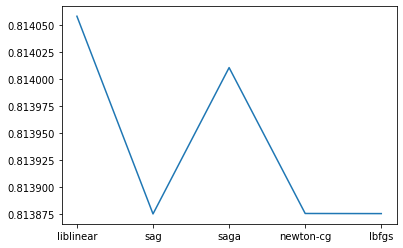

In [ ]:
print(gs.best_params_)
plt.plot(plt.plot(['liblinear', 'sag', 'saga', 'newton-cg', 'lbfgs'], gs.cv_results_['mean_test_score']))

In [ ]:
# final model: use best params from grid search
multi_LR_clf = MultiOutputClassifier(LogisticRegression(solver='liblinear')).fit(X_train, y_train) # ‘liblinear’, ‘sag’, ‘saga’

# # get a list of n_output containing probability arrays of shape (n_samples, n_classes)
y_pred = multi_LR_clf.predict_proba(X_test)
# extract the positive columns for each output
y_pred = np.transpose([pred[:, 1] for pred in y_pred])
scores = roc_auc_score(y_test, y_pred, average=None)

## Print final results: overall and separate for each tag

In [ ]:
roc_auc_scores = roc_auc_score(y_test, y_pred, average=None)

results = []
print("AVERAGE:", np.mean(roc_auc_scores))
for i in range(k):
  results.append( (top_k_tags[i], round(roc_auc_scores[i], 3)) )
  # print( top_k_tags[i], ":\t", round(roc_auc_scores[i], 3) )

results.sort(key = lambda x: x[1], reverse=True)
for row in results:
  print("{: <20} {: <7}".format(*row))

AVERAGE: 0.8283569336913913
Puzzle               0.897  
Horror               0.897  
Multiplayer          0.896  
Anime                0.892  
Gore                 0.888  
Shooter              0.883  
Platformer           0.881  
Fantasy              0.873  
Action               0.869  
Violent              0.866  
Arcade               0.866  
Story Rich           0.859  
Simulation           0.856  
First-Person         0.856  
Strategy             0.848  
Female Protagonist   0.839  
Adventure            0.838  
Early Access         0.83   
Retro                0.827  
Pixel Graphics       0.818  
Cute                 0.802  
Casual               0.789  
2D                   0.767  
Atmospheric          0.763  
Funny                0.76   
Free Play            0.759  
Great Soundtrack     0.757  
Indie                0.75   
Difficult            0.749  
Singleplayer         0.677  


In [ ]:
# Let's try it out by hand

# return the predicted labels
def label_description(model, example_description):
  s = preprocess(example_description)
  v = vectorizer.transform([s])
  preds = model.predict(v)
  print(preds)
  results = []
  for i in range(len(top_k_tags)):
    results.append( (top_k_tags[i], preds[0][i]) )
  results.sort(key = lambda x: x[1], reverse=True)
  return results
  return preds[0]



label_description(multi_KNN_clf, "A spiritual successor to FromSoftware's Demon's Souls, the game is the second installment in the Souls series. Dark Souls takes place in the kingdom of Lordran, where players assume the role of a cursed undead character who begins a pilgrimage to discover the fate of their kind.")


